In [1]:
import os
import cv2
import random
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, Model
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

import kagglehub

Download dataset from Kaggle

In [2]:
print("Downloading dataset from Kaggle...")
dataset_root = kagglehub.dataset_download(
    "ashwingupta3012/human-faces"
)
print("Dataset downloaded to:", dataset_root)

raw_images_dir = os.path.join(dataset_root, "Humans")
assert os.path.exists(raw_images_dir), "Humans folder not found"

image_files = [
    f for f in os.listdir(raw_images_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

print("Total images:", len(image_files))

100%|██████████| 1.82G/1.82G [00:20<00:00, 93.5MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1
Total images: 7219


Train / Test split

In [3]:
OUTPUT_ROOT = "dataset"
TRAIN_RATIO = 0.8
random.seed(42)

random.shuffle(image_files)
split = int(len(image_files) * TRAIN_RATIO)

train_files = image_files[:split]
test_files  = image_files[split:]

for split_name, files in [("train", train_files), ("test", test_files)]:
    out_dir = f"{OUTPUT_ROOT}/{split_name}/raw"
    os.makedirs(out_dir, exist_ok=True)
    for f in files:
        shutil.copy(
            os.path.join(raw_images_dir, f),
            os.path.join(out_dir, f)
        )

print("Train:", len(train_files))
print("Test :", len(test_files))

Train: 5775
Test : 1444


Resize HR / LR

In [4]:
HR_SIZE = 128
LR_SIZE = 32

def resize_folder(src, dst, size):
    os.makedirs(dst, exist_ok=True)
    for f in os.listdir(src):
        img = cv2.imread(os.path.join(src, f))
        if img is None:
            continue
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        cv2.imwrite(os.path.join(dst, f), img)

for split in ["train", "test"]:
    resize_folder(
        f"{OUTPUT_ROOT}/{split}/raw",
        f"{OUTPUT_ROOT}/{split}/hr",
        HR_SIZE
    )
    resize_folder(
        f"{OUTPUT_ROOT}/{split}/raw",
        f"{OUTPUT_ROOT}/{split}/lr",
        LR_SIZE
    )

Load LR / HR into memory

In [5]:
def load_pairs(lr_dir, hr_dir):
    X, Y = [], []
    files = sorted(os.listdir(lr_dir))

    for f in files:
        lr = cv2.imread(os.path.join(lr_dir, f))
        hr = cv2.imread(os.path.join(hr_dir, f))
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
        X.append(lr)
        Y.append(hr)

    X = np.array(X, dtype=np.float32) / 127.5 - 1
    Y = np.array(Y, dtype=np.float32) / 127.5 - 1
    return X, Y

In [6]:
train_lr, train_hr = load_pairs(
    "dataset/train/lr",
    "dataset/train/hr"
)
test_lr, test_hr = load_pairs(
    "dataset/test/lr",
    "dataset/test/hr"
)

print(train_lr.shape, train_hr.shape)

(5775, 32, 32, 3) (5775, 128, 128, 3)


Patch parameters

In [7]:
SCALE = 4
HR_PATCH = 64
LR_PATCH = HR_PATCH // SCALE

assert HR_PATCH % SCALE == 0

lr_shape = (LR_PATCH, LR_PATCH, 3)
hr_shape = (HR_PATCH, HR_PATCH, 3)

Random crop

In [8]:
def random_crop(lr, hr, lr_patch, scale):
    h, w, _ = lr.shape
    x = random.randint(0, w - lr_patch)
    y = random.randint(0, h - lr_patch)

    lr_crop = lr[y:y+lr_patch, x:x+lr_patch]
    hr_crop = hr[
        y*scale:(y+lr_patch)*scale,
        x*scale:(x+lr_patch)*scale
    ]
    return lr_crop, hr_crop

SCALE CHECKS

In [9]:
i = random.randint(0, len(train_lr)-1)
lr_p, hr_p = random_crop(train_lr[i], train_hr[i], LR_PATCH, SCALE)

print("LR patch:", lr_p.shape)
print("HR patch:", hr_p.shape)

LR patch: (16, 16, 3)
HR patch: (64, 64, 3)


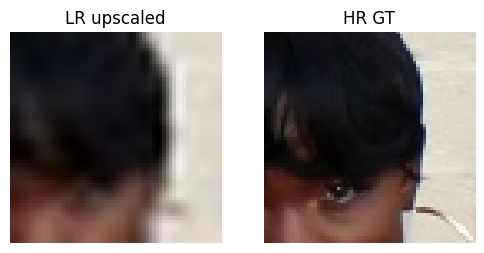

In [10]:
lr_up = cv2.resize(
    (lr_p + 1)/2,
    (HR_PATCH, HR_PATCH),
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("LR upscaled")
plt.imshow(lr_up)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("HR GT")
plt.imshow((hr_p + 1)/2)
plt.axis("off")
plt.show()

Models

Model components

In [11]:
from keras import layers, Model
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow import keras

Conv2D = layers.Conv2D
BatchNormalization = layers.BatchNormalization
PReLU = layers.PReLU
UpSampling2D = layers.UpSampling2D
LeakyReLU = layers.LeakyReLU
Input = layers.Input
add = layers.add
Flatten = layers.Flatten
Dense = layers.Dense


In [12]:
def res_block(x):
    y = Conv2D(64, 3, padding="same")(x)
    y = BatchNormalization(momentum=0.5)(y)
    y = PReLU(shared_axes=[1,2])(y)
    y = Conv2D(64, 3, padding="same")(y)
    y = BatchNormalization(momentum=0.5)(y)
    return add([x, y])


def upscale_block(x):
    x = Conv2D(256, 3, padding="same")(x)
    x = UpSampling2D(size=2)(x)
    x = PReLU(shared_axes=[1,2])(x)
    return x


Generator

In [13]:
def build_generator():
    lr_ip = Input(shape=(None, None, 3))

    x = Conv2D(64, 9, padding="same")(lr_ip)
    x = PReLU(shared_axes=[1,2])(x)

    skip = x
    for _ in range(8):
        x = res_block(x)

    x = Conv2D(64, 3, padding="same")(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = add([x, skip])

    x = upscale_block(x)
    x = upscale_block(x)

    out = Conv2D(3, 9, activation="tanh", padding="same")(x)
    return Model(lr_ip, out)


Discriminator

In [14]:
def disc_block(x, f, s=1):
    x = Conv2D(f, 3, strides=s, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    return x


def build_discriminator():
    ip = Input(shape=(HR_PATCH, HR_PATCH, 3))

    x = Conv2D(64, 3, padding="same")(ip)
    x = LeakyReLU(0.2)(x)

    x = disc_block(x, 64, 2)
    x = disc_block(x, 128)
    x = disc_block(x, 128, 2)
    x = disc_block(x, 256)
    x = disc_block(x, 256, 2)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)

    out = Dense(1, activation="sigmoid")(x)
    return Model(ip, out)


VGG perceptual model

In [15]:
def build_vgg():
    vgg = VGG19(
        weights="imagenet",
        include_top=False,
        input_shape=(HR_PATCH, HR_PATCH, 3)
    )
    vgg.trainable = False
    return Model(vgg.input, vgg.layers[9].output)


Compile models

In [16]:
generator = build_generator()

In [17]:
print("Pretraining generator (pixel-wise MSE)...")

generator.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(1e-4)
)

Pretraining generator (pixel-wise MSE)...


In [18]:
PRETRAIN_STEPS = 2000
PRETRAIN_BATCH = 4

for step in range(PRETRAIN_STEPS):
    lr_imgs, hr_imgs = [], []

    for _ in range(PRETRAIN_BATCH):
        i = np.random.randint(len(train_lr))
        lr_p, hr_p = random_crop(
            train_lr[i], train_hr[i],
            LR_PATCH, SCALE
        )
        lr_imgs.append(lr_p)
        hr_imgs.append(hr_p)

    lr_imgs = np.array(lr_imgs)
    hr_imgs = np.array(hr_imgs)

    loss = generator.train_on_batch(lr_imgs, hr_imgs)

    if step % 200 == 0:
        print(f"[Pretrain] step {step}/{PRETRAIN_STEPS} | loss: {loss:.4f}")

[Pretrain] step 0/2000 | loss: 0.3685
[Pretrain] step 200/2000 | loss: 0.0752
[Pretrain] step 400/2000 | loss: 0.0558
[Pretrain] step 600/2000 | loss: 0.0474
[Pretrain] step 800/2000 | loss: 0.0422
[Pretrain] step 1000/2000 | loss: 0.0386
[Pretrain] step 1200/2000 | loss: 0.0360
[Pretrain] step 1400/2000 | loss: 0.0338
[Pretrain] step 1600/2000 | loss: 0.0320
[Pretrain] step 1800/2000 | loss: 0.0305


In [19]:
generator.save("generator_pretrained.h5")
print("Pretrained generator saved")

Pretrained generator saved


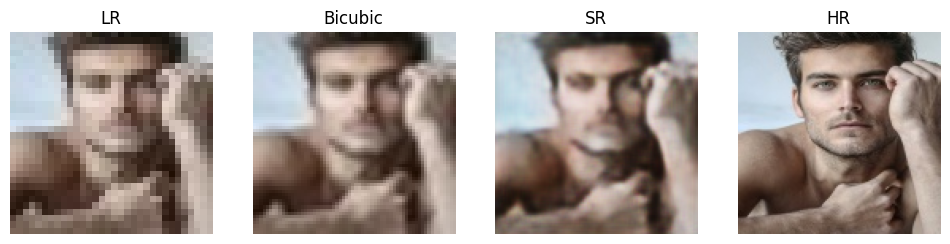

In [20]:
sr = generator.predict(test_lr[:1], verbose=0)[0]

lr_img = test_lr[0]
hr_img = test_hr[0]

bicubic = cv2.resize(
    (lr_img + 1) / 2,
    (HR_PATCH, HR_PATCH),
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
plt.title("LR")
plt.imshow((lr_img + 1) / 2)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Bicubic")
plt.imshow(bicubic)
plt.axis("off")

plt.subplot(1,4,3)
plt.title("SR")
plt.imshow((sr + 1) / 2)
plt.axis("off")

plt.subplot(1,4,4)
plt.title("HR")
plt.imshow((hr_img + 1) / 2)
plt.axis("off")

plt.show()

In [21]:
generator.trainable = True

In [22]:
discriminator = build_discriminator()
vgg = build_vgg()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
discriminator.trainable = True
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(1e-4)
)

In [24]:
discriminator.trainable = False

lr_ip = Input(shape=(LR_PATCH, LR_PATCH, 3))
fake_hr = generator(lr_ip)

validity = discriminator(fake_hr)
features = vgg(preprocess_input((fake_hr + 1) * 127.5))

srgan = Model(
    inputs=lr_ip,
    outputs=[validity, features]
)

srgan.compile(
    loss=["binary_crossentropy", "mse"],
    loss_weights=[1e-4, 1],
    optimizer=keras.optimizers.Adam(1e-4),
    run_eagerly=True
)

In [25]:
print("Generator trainable:", len(generator.trainable_weights))
print("Discriminator trainable:", len(discriminator.trainable_weights))
print("SRGAN trainable:", len(srgan.trainable_weights))


Generator trainable: 87
Discriminator trainable: 0
SRGAN trainable: 87


Patch-based training loop

In [26]:
epochs = 1
batch_size = 4
MAX_BATCHES = 1000

real = np.ones((batch_size, 1)) * 0.9
fake = np.zeros((batch_size, 1))

for e in range(epochs):
    idxs = np.random.permutation(len(train_lr))
    start = time.time()

    for step, i in enumerate(range(0, len(idxs) - batch_size, batch_size)):
        if step >= MAX_BATCHES:
            break

        b = idxs[i:i+batch_size]
        lr_imgs, hr_imgs = [], []

        for j in b:
            lr_p, hr_p = random_crop(
                train_lr[j], train_hr[j],
                LR_PATCH, SCALE
            )
            lr_imgs.append(lr_p)
            hr_imgs.append(hr_p)

        lr_imgs = np.array(lr_imgs)
        hr_imgs = np.array(hr_imgs)

        # --- train discriminator ---
        discriminator.trainable = True

        fake_hr = generator.predict(lr_imgs, verbose=0)
        discriminator.train_on_batch(hr_imgs, real)
        discriminator.train_on_batch(fake_hr, fake)

        # --- train generator ---
        discriminator.trainable = False

        real_feat = vgg(
            preprocess_input((hr_imgs + 1) * 127.5),
            verbose=0
        )

        srgan.train_on_batch(
            lr_imgs,
            [real, real_feat]
        )

    print(f"Epoch {e+1} done in {(time.time()-start)/60:.1f} min")
    generator.save(f"generator_srgan_epoch_{e+1}.h5")
    print("Generator checkpoint saved")


Epoch 1 done in 95.6 min
Generator checkpoint saved


Inference check

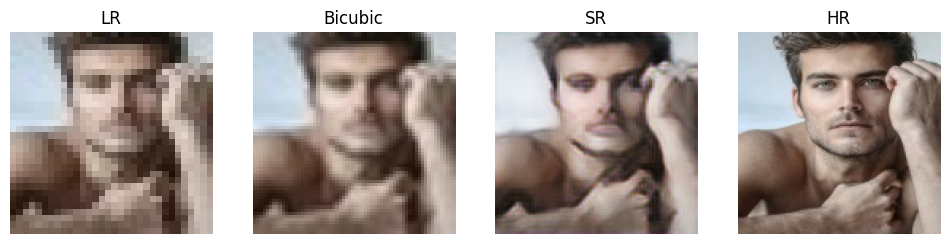

In [27]:
sr = generator.predict(test_lr[:1], verbose=0)[0]

lr_img = test_lr[0]
hr_img = test_hr[0]

bicubic = cv2.resize(
    (lr_img + 1) / 2,
    (HR_PATCH, HR_PATCH),
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
plt.title("LR")
plt.imshow((lr_img + 1) / 2)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Bicubic")
plt.imshow(bicubic)
plt.axis("off")

plt.subplot(1,4,3)
plt.title("SR")
plt.imshow((sr + 1) / 2)
plt.axis("off")

plt.subplot(1,4,4)
plt.title("HR")
plt.imshow((hr_img + 1) / 2)
plt.axis("off")

plt.show()